In [1]:
import pandas
import matplotlib.pyplot as plt

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import os
from datetime import datetime
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score

import mlflow
from transformers import TrainerCallback
from mlflow.tracking import MlflowClient
from mlflow.exceptions import MlflowException
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [2]:
data_train = pandas.read_csv('/data/Training_Data.csv')
data_test = pandas.read_csv('/data/Query_and_Validation_Data.csv')

# 1. Dataset exploration

In [3]:
data_train.head()

,product_description,Category
0,cookies cakes Chocolate Sandwich Cookies,Dry Goods & Pantry Staples
1,spices seasonings All-Seasons Salt,Dry Goods & Pantry Staples
2,Robust Golden Unsweetened Oolong Tea,Beverages
3,frozen meals Smart Ones Classic Favorites Mini...,Fresh & Perishable Items
4,marinades meat preparation Green Chile Anytime...,Dry Goods & Pantry Staples


In [4]:
data_test.head()

,product_description,HUMAN_VERIFIED_Category
0,Fair Trade 100% Pure Organic Honey,NaN
1,Organic Balsamic Vinegar Of Modena,NaN
2,"Cheesecake, Chocolate Truffle",NaN
3,White Multifold Towels,Household & Personal Care
4,Sourdough Deli Bread,Fresh & Perishable Items


In [5]:
data_test.dtypes

product_description        object
HUMAN_VERIFIED_Category    object
dtype: object

In [6]:
data_train['Category'].value_counts()

Category
Dry Goods & Pantry Staples    15147
Fresh & Perishable Items      11636
Household & Personal Care     10637
Beverages                      4926
Specialty & Miscellaneous      2654
Name: count, dtype: int64

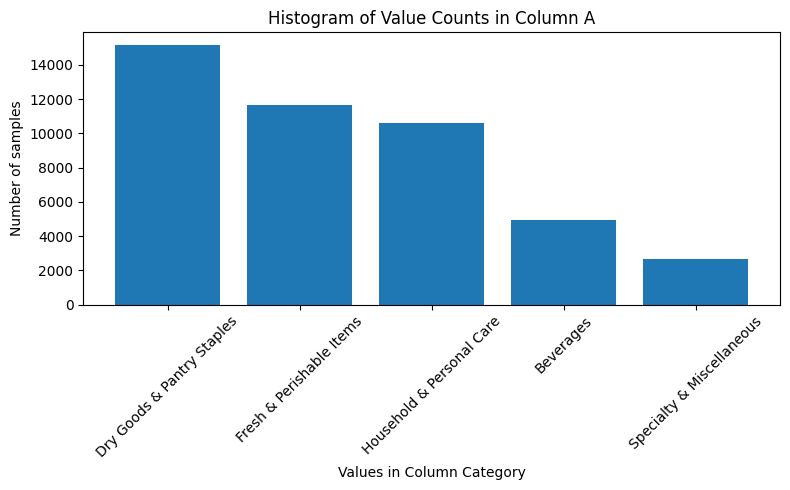

In [7]:
value_counts = data_train['Category'].value_counts()

plt.figure(figsize=(8, 5))
plt.bar(value_counts.index, value_counts.values)
plt.xlabel('Values in Column Category')
plt.ylabel('Number of samples')
plt.title('Histogram of Value Counts in Column A')
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()

There's data imbalance in labels distribution. For training we have to take it into consideration to use class_weights or oversampling/undersampling techniques

Let's check input sequence len distribution

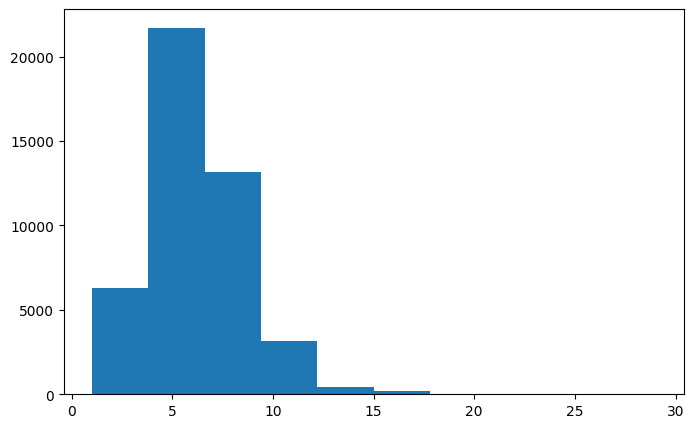

In [8]:
num_words = list()

for description in data_train['product_description']:
    # print(description)
    num_words.append(len(description.split(' ')))
    # break

plt.figure(figsize=(8, 5))
plt.hist(num_words)
plt.show()

input sequence lenght disctibution is fine, it's not bigger that model's `max_input_len`

# 2. Prepare training dataset

In [ ]:
label_to_num_map = {
    'Dry Goods & Pantry Staples': 0,
    'Fresh & Perishable Items': 1,
    'Household & Personal Care': 2,
    'Beverages': 3,
    'Specialty & Miscellaneous': 4
}

data_train['category_index'] = data_train.apply(lambda x: label_to_num_map[x['Category']], axis=1)

In [ ]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

data_to_split = data_train#.sample(1000)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    data_to_split['product_description'], data_to_split['category_index'], test_size=0.2, random_state=42
)

In [ ]:
data_train.sample(10)

# 3. Run training experiments

In [ ]:
class GetActiveRunCallback(TrainerCallback):
    def on_train_begin(self, args, state, control, **kwargs):
        if not mlflow.active_run():
            mlflow.start_run()
        self.run_id = mlflow.active_run().info.run_id
        print(f"MLflow RUN_ID at start of training: {self.run_id}")

    def on_train_end(self, args, state, control, **kwargs):
        print(f"MLflow RUN_ID at end of training: {self.run_id}")
        mlflow.end_run()

active_run_id_callback = GetActiveRunCallback()

In [ ]:
os.environ["MLFLOW_EXPERIMENT_NAME"] = "test1"
os.environ["MLFLOW_TRACKING_URI"] = "http://mlflow:5000"
os.environ["HF_MLFLOW_LOG_ARTIFACTS"] = "False"

os.environ["AWS_ACCESS_KEY_ID"] = "minio_user"
os.environ["AWS_SECRET_ACCESS_KEY"] = "minio_password"
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "http://minio:9000"

In [ ]:
class WeightedBERT(BertForSequenceClassification):
    def __init__(self, config, class_weights):
        super().__init__(config)
        self.class_weights = class_weights

    def compute_loss(self, outputs, labels):
        loss_fn = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(outputs.logits.device))
        loss = loss_fn(outputs.logits, labels)
        return loss

# Calculate class weights
labels = data_train['category_index']
class_weights = compute_class_weight(
    class_weight='balanced',  
    classes=np.array(range(5)), 
    y=labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float)
# class_weights

model_name = 'bert-base-uncased'

tokenizer = BertTokenizer.from_pretrained(model_name)

train_dataset = TextClassificationDataset(train_texts.tolist(), train_labels.tolist(), tokenizer)
val_dataset = TextClassificationDataset(val_texts.tolist(), val_labels.tolist(), tokenizer)

# model = BertForSequenceClassification.from_pretrained(model_name, num_labels=5)
model = WeightedBERT.from_pretrained(model_name, num_labels=5, class_weights=class_weights)

run_name = f"{model_name}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=7,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=200,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    run_name=run_name,
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    f1_for_each_class = f1_score(labels, preds, average=None)
    # acc = accuracy_score(labels, preds)
    return {
        # 'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'f1_for_each_class': f1_for_each_class.tolist(),
        'f1_min': min(f1_for_each_class),
    }


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[active_run_id_callback]
)


trainer.train()


trainer.save_model("./text_classification_model")

In [ ]:
import gc

del model
del trainer
torch.cuda.empty_cache()  # Clear GPU memory
gc.collect()  # Collect unused Python objects

In [ ]:
print(mlflow.active_run())

In [ ]:
run_id = active_run_id_callback.run_id
run_id

In [ ]:
# from mlflow.tracking import MlflowClient

client = MlflowClient()
run_id = "9acee285129b429ba9243103cac82ff4"  # Replace with the run ID of your model
# run_id = "839e49b73ab448be98ec082588d7625e"  # Replace with the run ID of your model
# artifacts = client.list_artifacts(run_id,) #path="model-checkpoints")

# print(artifacts)
# # Find the best checkpoint based on custom logic
# best_checkpoint_path = None
# for artifact in artifacts:
#     # if "best" in artifact.path:  # Example logic to find the best
#     #     best_checkpoint_path = artifact.path
#     #     break
#     print(artifact)
#     break

# print(f"Best checkpoint: {best_checkpoint_path}")

In [ ]:
# client.get_run(run_id).data

In [ ]:
import numpy as np

def get_best_step(run_id, metric):
    metric_history = client.get_metric_history(run_id, metric)
    metric_list = [i.value for i in metric_history]
    max_metric_index = np.argmax(metric_list)

    f1_history = client.get_metric_history(run_id, 'eval_f1')
    f1_min_history = client.get_metric_history(run_id, 'eval_f1_min')

    return {
        "best_checkpoint": f"checkpoint-{metric_history[max_metric_index].step}", 
        "best_f1": f1_history[max_metric_index].value,
        "best_f1_min": f1_min_history[max_metric_index].value
    }

# def find_best_checkpoint_path(run_id, metric):
#     return f"checkpoint-{get_best_step(run_id, metric).step}"

def find_best_f1(run_id, metric):
    return get_best_step(run_id, metric)

checkpoint_name = get_best_step(run_id, 'eval_f1_min')['best_checkpoint']
checkpoint_name

In [ ]:
get_best_step(run_id, 'eval_f1_min')

In [ ]:
find_best_f1(run_id, 'eval_f1_min')
client.get_metric_history(run_id, 'eval_f1')

In [ ]:
artifacts_download_dir = os.path.join(f'/tmp/{run_id}')

if not os.path.exists(artifacts_download_dir):
    os.makedirs(artifacts_download_dir)

try:
    client.download_artifacts(run_id, checkpoint_name, artifacts_download_dir)
except MlflowException as e:
    print(f"Exception occured: {e}") 

    # s3://mlflow/1/9acee285129b429ba9243103cac82ff4/artifacts/checkpoint-6750

# 4. Load best model from checkpoint and evaluate it on test set with human feedback

In [ ]:
saved_checkpoint_path = os.path.join(artifacts_download_dir, checkpoint_name, "artifacts", checkpoint_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer_loaded = BertTokenizer.from_pretrained(saved_checkpoint_path)
model_loaded = BertForSequenceClassification.from_pretrained(saved_checkpoint_path).to(device)
model_loaded.eval()


In [ ]:
text = "Some text"
texts = ["text1", "text2"]
texts = ["text1"]





input_ids = tokenizer_loaded(texts, 
                 max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors="pt").to(device)

# model_loaded(input_ids)
preds = model_loaded(**input_ids)
# preds.logits, 
pred_idxs = torch.argmax(preds.logits, dim=1)
pred_idxs.cpu().numpy().tolist()

# def predict_file(filepath):
    

In [ ]:
def predict_on_batch(tokenizer, model, batch):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    input_ids = tokenizer(batch, 
              max_length=128,
              padding='max_length',
              truncation=True,
              return_tensors="pt").to(device)
    preds = model(**input_ids)
    return torch.argmax(preds.logits, dim=1)


def process_in_batches(elements, batch_size):
    """
    Iterates through a list in batches of size N.

    :param elements: List of elements to process.
    :param batch_size: Size of each batch.
    """
    predictions_combined = list()
    for i in range(0, len(elements), batch_size):
        batch = elements[i:i + batch_size]
        # Process the current batch
        # print(f"Processing batch: {batch}")
        # Add your processing logic here
        batch_prediction = predict_on_batch(tokenizer_loaded, model_loaded, batch)
        predictions_combined.extend(batch_prediction.cpu().numpy().astype(np.int32).tolist())

    return predictions_combined

def get_class_titles(labelmap, class_values):
    value_to_title = {value: title for title, value in labelmap.items()}
    class_titles = [value_to_title.get(value, "Unknown") for value in class_values]

    return class_titles

predictions = process_in_batches(data_test['product_description'].values.tolist(), 64)
get_class_titles(label_to_num_map, predictions)

In [ ]:
data_test_copy = data_test.copy()
data_test_copy['predictions'] = predictions
data_test_copy['category_index'] = data_test_copy.apply(lambda x: label_to_num_map[x['HUMAN_VERIFIED_Category']] 
                                                        if not pandas.isnull(x['HUMAN_VERIFIED_Category']) else np.nan, axis=1)

In [ ]:
data_test_copy.head()

In [ ]:
# f1_score(y_true, y_pred, average=None)
y_true = data_test_copy[~pandas.isnull(data_test_copy['HUMAN_VERIFIED_Category'])]['category_index']
y_pred = data_test_copy[~pandas.isnull(data_test_copy['HUMAN_VERIFIED_Category'])]['predictions']

f1_score(y_true, y_pred, average=None)

In [ ]:
pandas.isnull(data_test_copy.loc[0]['HUMAN_VERIFIED_Category'])
data_test_copy[~pandas.isnull(data_test_copy['HUMAN_VERIFIED_Category'])]
type(data_test_copy.loc[0]['HUMAN_VERIFIED_Category'])

In [ ]:
experiment_name = "test1"
experiment = mlflow.get_experiment_by_name(experiment_name)
print(experiment)
# Find the best run based on your target metric
best_run = None
best_metric = float('inf')  # or '-inf' for maximizing metrics
for run in mlflow.search_runs(experiment_ids=[experiment.experiment_id]):
    print(run)
    metric_value = run.data.metrics['validation_loss']  # Replace with your metric
    if metric_value < best_metric:  # Adjust comparison based on your objective
        best_metric = metric_value
        best_run = run

# Get the checkpoint path from the best run's artifacts
if best_run:
    checkpoint_path = f"{best_run.info.artifact_uri}/checkpoints"
    print(f"Best checkpoint path: {checkpoint_path}")
    # model = BertForSequenceClassification.from_pretrained(checkpoint_path)
else:
    print("No suitable runs found.")

In [ ]:
import transformers

task = "text-classification"

my_pipeline = transformers.pipeline(
    task=task,
    model=trainer.model,
    tokenizer=tokenizer,
    framework="pt",
)

In [ ]:
my_pipeline.predict("Sourdough Deli Bread")

In [ ]:
mlflow.sklearn.log_model(my_pipeline, artifact_path="model", registered_model_name="my_model")

In [ ]:
result = mlflow.register_model(
    "runs:/9acee285129b429ba9243103cac82ff4/checkpoint-6750", "bert-test-inference"
)

In [ ]:
result

In [ ]:
loaded_pipeline = mlflow.transformers.load_model(
    model_info.model_uri, return_type="pipeline", torch_dtype=torch.float64
)

print(loaded_pipeline.torch_dtype)

In [ ]:
import mlflow
logged_model = 'runs:/9acee285129b429ba9243103cac82ff4/checkpoint-6750'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
# import pandas as pd
loaded_model.predict(data_test)

In [ ]:
# loaded_model.predict(data_test)
loaded_model.predict("cookies cookies")

In [ ]:
text = "car"
train_dataset.tokenizer(
            text,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

In [ ]:
text = "car Car cat"
train_dataset.tokenizer(
            text,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

In [ ]:
data_train.sample(1)

In [ ]:
data_test.sample(10)

In [ ]:
data_test['HUMAN_VERIFIED_Category'].value_counts()